In [1]:
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import seaborn as sns
import torch
import torch.distributions as dist
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim
import pyro.distributions.transforms as T
from torch.autograd import Variable

In [2]:
%config InlineBackend.figure_format='retina'
sns.set()

In [3]:
DEFAULT_MIN_BIN_WIDTH = 1e-3
DEFAULT_MIN_BIN_HEIGHT = 1e-3
DEFAULT_MIN_DERIVATIVE = 1e-3

def searchsorted(bin_locations, inputs, eps=1e-6):
    bin_locations[..., -1] += eps
    return torch.sum(
        inputs[..., None] >= bin_locations,
        dim=-1
    ) - 1

def unconstrained_RQS(inputs, unnormalized_widths, unnormalized_heights,
                      unnormalized_derivatives, inverse=False,
                      tail_bound=1., min_bin_width=DEFAULT_MIN_BIN_WIDTH,
                      min_bin_height=DEFAULT_MIN_BIN_HEIGHT,
                      min_derivative=DEFAULT_MIN_DERIVATIVE):
    inside_intvl_mask = (inputs >= -tail_bound) & (inputs <= tail_bound)
    outside_interval_mask = ~inside_intvl_mask

    outputs = torch.zeros_like(inputs)
    logabsdet = torch.zeros_like(inputs)

    unnormalized_derivatives = F.pad(unnormalized_derivatives, pad=(1, 1))
    constant = np.log(np.exp(1 - min_derivative) - 1)
    unnormalized_derivatives[..., 0] = constant
    unnormalized_derivatives[..., -1] = constant

    outputs[outside_interval_mask] = inputs[outside_interval_mask]
    logabsdet[outside_interval_mask] = 0

    outputs[inside_intvl_mask], logabsdet[inside_intvl_mask] = RQS(
        inputs=inputs[inside_intvl_mask],
        unnormalized_widths=unnormalized_widths[inside_intvl_mask, :],
        unnormalized_heights=unnormalized_heights[inside_intvl_mask, :],
        unnormalized_derivatives=unnormalized_derivatives[inside_intvl_mask, :],
        inverse=inverse,
        left=-tail_bound, right=tail_bound, bottom=-tail_bound, top=tail_bound,
        min_bin_width=min_bin_width,
        min_bin_height=min_bin_height,
        min_derivative=min_derivative
    )
    return outputs, logabsdet

In [4]:
def RQS(inputs, unnormalized_widths, unnormalized_heights,
        unnormalized_derivatives, inverse=False, left=0., right=1.,
        bottom=0., top=1., min_bin_width=DEFAULT_MIN_BIN_WIDTH,
        min_bin_height=DEFAULT_MIN_BIN_HEIGHT,
        min_derivative=DEFAULT_MIN_DERIVATIVE):
    if torch.min(inputs) < left or torch.max(inputs) > right:
        raise ValueError("Input outside domain")

    num_bins = unnormalized_widths.shape[-1]

    if min_bin_width * num_bins > 1.0:
        raise ValueError('Minimal bin width too large for the number of bins')
    if min_bin_height * num_bins > 1.0:
        raise ValueError('Minimal bin height too large for the number of bins')

    widths = F.softmax(unnormalized_widths, dim=-1)
    widths = min_bin_width + (1 - min_bin_width * num_bins) * widths
    cumwidths = torch.cumsum(widths, dim=-1)
    cumwidths = F.pad(cumwidths, pad=(1, 0), mode='constant', value=0.0)
    cumwidths = (right - left) * cumwidths + left
    cumwidths[..., 0] = left
    cumwidths[..., -1] = right
    widths = cumwidths[..., 1:] - cumwidths[..., :-1]

    derivatives = min_derivative + F.softplus(unnormalized_derivatives)

    heights = F.softmax(unnormalized_heights, dim=-1)
    heights = min_bin_height + (1 - min_bin_height * num_bins) * heights
    cumheights = torch.cumsum(heights, dim=-1)
    cumheights = F.pad(cumheights, pad=(1, 0), mode='constant', value=0.0)
    cumheights = (top - bottom) * cumheights + bottom
    cumheights[..., 0] = bottom
    cumheights[..., -1] = top
    heights = cumheights[..., 1:] - cumheights[..., :-1]

    if inverse:
        bin_idx = searchsorted(cumheights, inputs)[..., None]
    else:
        bin_idx = searchsorted(cumwidths, inputs)[..., None]

    input_cumwidths = cumwidths.gather(-1, bin_idx)[..., 0]
    input_bin_widths = widths.gather(-1, bin_idx)[..., 0]

    input_cumheights = cumheights.gather(-1, bin_idx)[..., 0]
    delta = heights / widths
    input_delta = delta.gather(-1, bin_idx)[..., 0]

    input_derivatives = derivatives.gather(-1, bin_idx)[..., 0]
    input_derivatives_plus_one = derivatives[..., 1:].gather(-1, bin_idx)
    input_derivatives_plus_one = input_derivatives_plus_one[..., 0]

    input_heights = heights.gather(-1, bin_idx)[..., 0]

    if inverse:
        a = (((inputs - input_cumheights) * (input_derivatives \
            + input_derivatives_plus_one - 2 * input_delta) \
            + input_heights * (input_delta - input_derivatives)))
        b = (input_heights * input_derivatives - (inputs - input_cumheights) \
            * (input_derivatives + input_derivatives_plus_one \
            - 2 * input_delta))
        c = - input_delta * (inputs - input_cumheights)

        discriminant = b.pow(2) - 4 * a * c
        assert (discriminant >= 0).all()

        root = (2 * c) / (-b - torch.sqrt(discriminant))
        outputs = root * input_bin_widths + input_cumwidths

        theta_one_minus_theta = root * (1 - root)
        denominator = input_delta \
                      + ((input_derivatives + input_derivatives_plus_one \
                      - 2 * input_delta) * theta_one_minus_theta)
        derivative_numerator = input_delta.pow(2) \
                               * (input_derivatives_plus_one * root.pow(2) \
                                + 2 * input_delta * theta_one_minus_theta \
                                + input_derivatives * (1 - root).pow(2))
        logabsdet = torch.log(derivative_numerator) - 2 * torch.log(denominator)
        return outputs, -logabsdet
    else:
        theta = (inputs - input_cumwidths) / input_bin_widths
        theta_one_minus_theta = theta * (1 - theta)

        numerator = input_heights * (input_delta * theta.pow(2) \
                    + input_derivatives * theta_one_minus_theta)
        denominator = input_delta + ((input_derivatives \
                      + input_derivatives_plus_one - 2 * input_delta) \
                      * theta_one_minus_theta)
        outputs = input_cumheights + numerator / denominator

        derivative_numerator = input_delta.pow(2) \
                               * (input_derivatives_plus_one * theta.pow(2) \
                                + 2 * input_delta * theta_one_minus_theta \
                                + input_derivatives * (1 - theta).pow(2))
        logabsdet = torch.log(derivative_numerator) - 2 * torch.log(denominator)
        return outputs, logabsdet

In [5]:
def safe_log(z):
    return torch.log(z + 1e-7)

In [6]:
def p_z(z):

    z1, z2 = torch.chunk(z, chunks=2, dim=1)
    norm = torch.sqrt(z1 ** 2 + z2 ** 2)

    exp1 = torch.exp(-0.5 * ((z1 - 2) / 0.8) ** 2)
    exp2 = torch.exp(-0.5 * ((z1 + 2) / 0.8) ** 2)
    u = 0.5 * ((norm - 4) / 0.4) ** 2 - torch.log(exp1 + exp2)

    return torch.exp(-u)

In [7]:
import torch
import torch.nn as nn


class NormalizingFlowModel(nn.Module):

    def __init__(self, prior, flows):
        super().__init__()
        self.prior = prior
        self.flows = nn.ModuleList(flows)

    def forward(self, x):
        m, _ = x.shape
        log_det = torch.zeros(m)
        for flow in self.flows:
            x, ld = flow.forward(x)
            log_det += ld
        z, prior_logprob = x, self.prior.log_prob(x)
        return z, prior_logprob, log_det

    def inverse(self, z):
        m, _ = z.shape
        log_det = torch.zeros(m)
        for flow in self.flows[::-1]:
            z, ld = flow.inverse(z)
            log_det += ld
        x = z
        return x, log_det

    def sample(self, n_samples):
        z = self.prior.sample((n_samples,))
        x, _ = self.inverse(z)
        return x

In [8]:
class FCNN(nn.Module):
    """
    Simple fully connected neural network.
    """
    def __init__(self, in_dim, out_dim, hidden_dim):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, out_dim),
        )

    def forward(self, x):
        return self.network(x)

In [9]:
class NSF_AR(nn.Module):
    """
    Neural spline flow, auto-regressive.
    [Durkan et al. 2019]
    """
    def __init__(self, dim, K = 5, B = 3, hidden_dim = 8, base_network = FCNN):
        super().__init__()
        self.dim = dim
        self.K = K
        self.B = B
        self.layers = nn.ModuleList()
        self.init_param = nn.Parameter(torch.Tensor(3 * K - 1))
        for i in range(1, dim):
            self.layers += [base_network(i, 3 * K - 1, hidden_dim)]
        self.reset_parameters()

    def reset_parameters(self):
        init.uniform_(self.init_param, - 1 / 2, 1 / 2)

    def forward(self, x):
        z = torch.zeros_like(x)
        log_det = torch.zeros(z.shape[0])
        for i in range(self.dim):
            if i == 0:
                init_param = self.init_param.expand(x.shape[0], 3 * self.K - 1)
                W, H, D = torch.split(init_param, self.K, dim = 1)
            else:
                out = self.layers[i - 1](x[:, :i])
                W, H, D = torch.split(out, self.K, dim = 1)
            W, H = torch.softmax(W, dim = 1), torch.softmax(H, dim = 1)
            W, H = 2 * self.B * W, 2 * self.B * H
            D = F.softplus(D)
            z[:, i], ld = unconstrained_RQS(
                x[:, i], W, H, D, inverse=False, tail_bound=self.B)
            log_det += ld
        return z, log_det

    def inverse(self, z):
        x = torch.zeros_like(z)
        log_det = torch.zeros(x.shape[0])
        for i in range(self.dim):
            if i == 0:
                init_param = self.init_param.expand(x.shape[0], 3 * self.K - 1)
                W, H, D = torch.split(init_param, self.K, dim = 1)
            else:
                out = self.layers[i - 1](x[:, :i])
                W, H, D = torch.split(out, self.K, dim = 1)
            W, H = torch.softmax(W, dim = 1), torch.softmax(H, dim = 1)
            W, H = 2 * self.B * W, 2 * self.B * H
            D = F.softplus(D)
            x[:, i], ld = unconstrained_RQS(
                z[:, i], W, H, D, inverse = True, tail_bound = self.B)
            log_det += ld
        return x, log_det


class NSF_CL(nn.Module):
    """
    Neural spline flow, coupling layer.
    [Durkan et al. 2019]
    """
    def __init__(self, dim, K = 5, B = 3, hidden_dim = 8, base_network = FCNN):
        super().__init__()
        self.dim = dim
        self.K = K
        self.B = B
        self.f1 = base_network(dim // 2, (3 * K - 1) * dim // 2, hidden_dim)
        self.f2 = base_network(dim // 2, (3 * K - 1) * dim // 2, hidden_dim)

    def forward(self, x):
        log_det = torch.zeros(x.shape[0])
        lower, upper = x[:, :self.dim // 2], x[:, self.dim // 2:]
        out = self.f1(lower).reshape(-1, self.dim // 2, 3 * self.K - 1)
        W, H, D = torch.split(out, self.K, dim = 2)
        W, H = torch.softmax(W, dim = 2), torch.softmax(H, dim = 2)
        W, H = 2 * self.B * W, 2 * self.B * H
        D = F.softplus(D)
        upper, ld = unconstrained_RQS(
            upper, W, H, D, inverse=False, tail_bound=self.B)
        log_det += torch.sum(ld, dim = 1)
        out = self.f2(upper).reshape(-1, self.dim // 2, 3 * self.K - 1)
        W, H, D = torch.split(out, self.K, dim = 2)
        W, H = torch.softmax(W, dim = 2), torch.softmax(H, dim = 2)
        W, H = 2 * self.B * W, 2 * self.B * H
        D = F.softplus(D)
        lower, ld = unconstrained_RQS(
            lower, W, H, D, inverse=False, tail_bound=self.B)
        log_det += torch.sum(ld, dim = 1)
        return torch.cat([lower, upper], dim = 1), log_det

    def inverse(self, z):
        log_det = torch.zeros(z.shape[0])
        lower, upper = z[:, :self.dim // 2], z[:, self.dim // 2:]
        out = self.f2(upper).reshape(-1, self.dim // 2, 3 * self.K - 1)
        W, H, D = torch.split(out, self.K, dim = 2)
        W, H = torch.softmax(W, dim = 2), torch.softmax(H, dim = 2)
        W, H = 2 * self.B * W, 2 * self.B * H
        D = F.softplus(D)
        lower, ld = unconstrained_RQS(
            lower, W, H, D, inverse=True, tail_bound=self.B)
        log_det += torch.sum(ld, dim = 1)
        out = self.f1(lower).reshape(-1, self.dim // 2, 3 * self.K - 1)
        W, H, D = torch.split(out, self.K, dim = 2)
        W, H = torch.softmax(W, dim = 2), torch.softmax(H, dim = 2)
        W, H = 2 * self.B * W, 2 * self.B * H
        D = F.softplus(D)
        upper, ld = unconstrained_RQS(
            upper, W, H, D, inverse = True, tail_bound = self.B)
        log_det += torch.sum(ld, dim = 1)
        return torch.cat([lower, upper], dim = 1), log_det

In [15]:
def random_normal_samples(n, dim=2):
    return torch.zeros(n, dim).normal_(mean=0, std=1)

def det_loss(model, n_samples=1000):
    
    x = random_normal_samples(n_samples)
    zk, prior_logprob, log_det = model(x)
    
    ln_q0 = prior_logprob.sum()
    
    sum_of_log_jacobians = log_det.sum()

    ll = safe_log(p_z(zk)).sum()

    return (ln_q0 - sum_of_log_jacobians - ll) / n_samples

In [19]:
def train(flow_length=16, epochs=1000, batch_size=40):
    
    flows = [NSF_CL(dim=2) for _ in range(flow_length)]
    
    prior = dist.MultivariateNormal(torch.zeros(2), torch.eye(2))
    model = NormalizingFlowModel(prior, flows)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    
    hist_loss = np.zeros(epochs)
    
    with tqdm(total=epochs) as pbar:
        
        for i in range(epochs):
            
            optimizer.zero_grad()
            
            loss = det_loss(model)
            
            loss.backward()
            optimizer.step()
            
            hist_loss[i] = loss.item()
            
            if i % 50 == 0 and i > 0:
                pbar.set_postfix({'loss': np.mean(hist_loss[i-50:i])})

            pbar.update()
            
    return model, hist_loss

In [20]:
%%time
flow, hist_loss = train(epochs=400)

  0%|          | 0/400 [00:00<?, ?it/s]

CPU times: user 55.6 s, sys: 2.12 s, total: 57.7 s
Wall time: 57.1 s


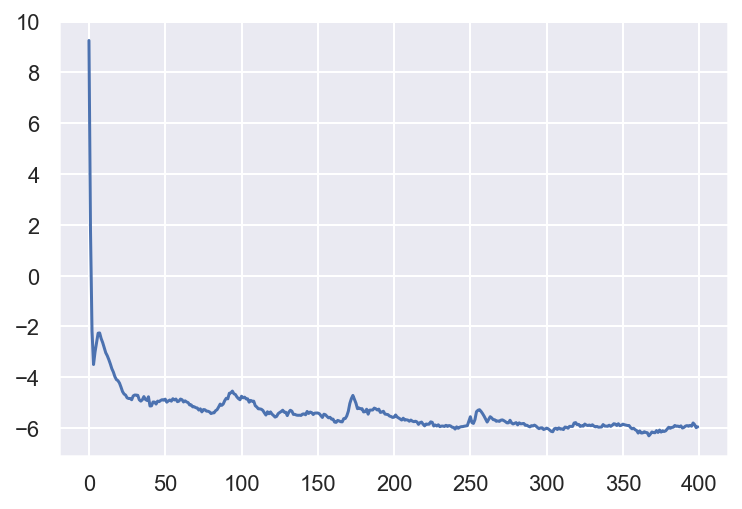

In [21]:
plt.plot(hist_loss);

In [22]:
def scatter_points(points):

    X_LIMS = (-7, 7)
    Y_LIMS = (-7, 7)

    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111)
    ax.scatter(points[:, 0], points[:, 1], alpha=0.7, s=25)
    ax.set_xlim(*X_LIMS)
    ax.set_ylim(*Y_LIMS)

    plt.show()

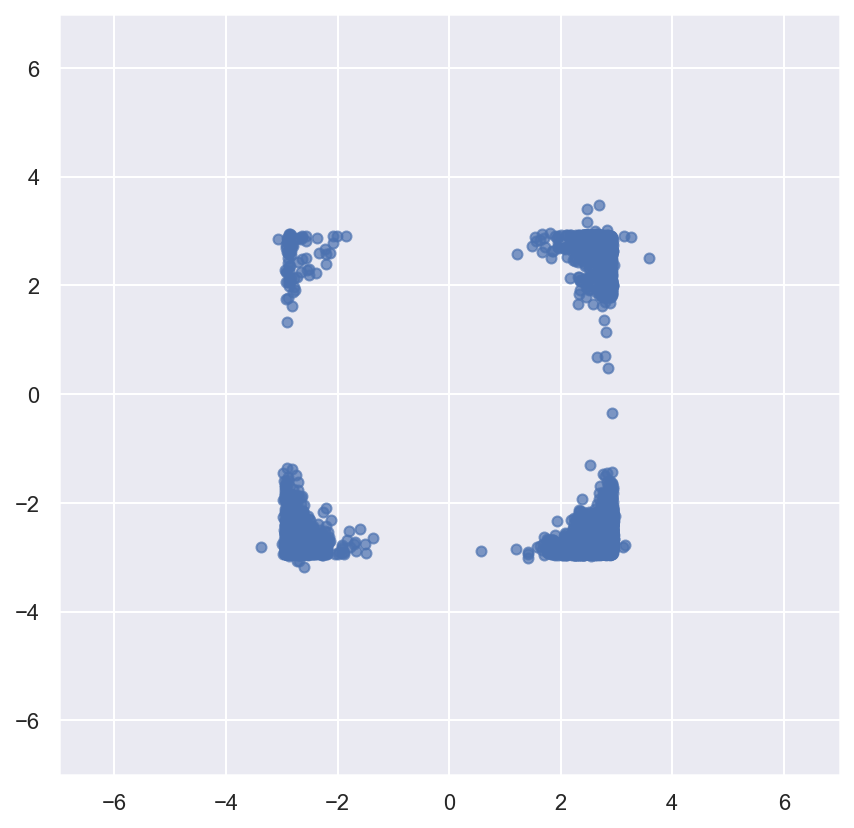

In [26]:
x = random_normal_samples(4000)
zk, prior_logprob, log_det = flow(x)
scatter_points(zk.data.numpy())

In [176]:
def plot_density(density):

    X_LIMS = (-7, 7)
    Y_LIMS = (-7, 7)

    x1 = np.linspace(*X_LIMS, 300)
    x2 = np.linspace(*Y_LIMS, 300)
    x1, x2 = np.meshgrid(x1, x2)
    shape = x1.shape
    x1_r = x1.ravel()
    x2_r = x2.ravel()

    z = np.c_[x1_r, x2_r]
    z = torch.from_numpy(z)

    density_values = density(z).data.numpy().reshape(shape)

    fig, ax = plt.subplots(figsize=(7, 7))
    ax.contourf(x1, x2, density_values, cmap='viridis')
    ax.set_title("True density")
    plt.xlabel('$z_1$')
    plt.ylabel('$z_2$')
    plt.show()

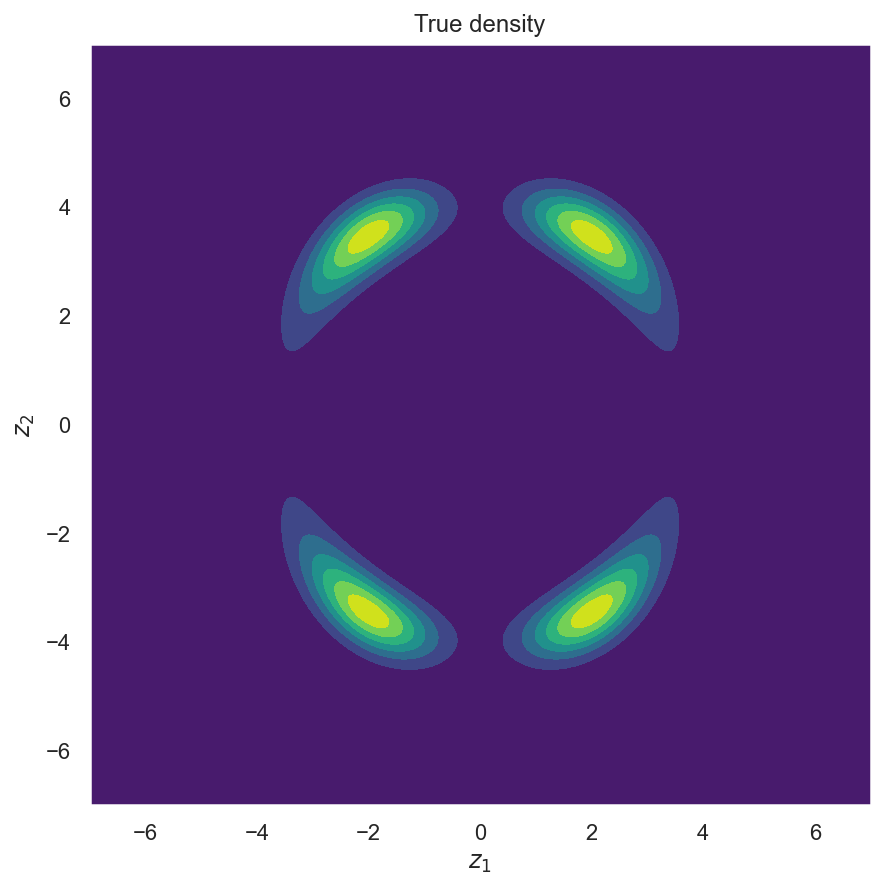

In [177]:
plot_density(p_z)